In [10]:
# Imports
import os
import pandas as pd
from functions import preprocess_files, create_current_path, topics_to_excel, dominant_topics, plot_topics, coherence_heatmap
from gensim.models import LdaModel, LdaMulticore
from gensim.corpora import Dictionary
from gensim.models.phrases import Phrases, Phraser
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import pyLDAvis.gensim
from bs4 import BeautifulSoup
pyLDAvis.enable_notebook()

## Przygotowanie korpusu tekstów do analizy

Pierwszym krokiem modelowania tematycznego jest odpowiednie przygotowanie korpusu do analizy. Dokumenty tekstowe należy sprowadzić do postaci plików `.vrt`, `.ccl`, `.txt` (w tym przypadku pliki powinny być wcześniej zlematyzowane). Do generowania korpusu w formacie `.ccl` można wykorzystać skrypt udostępniany za pośrednictwem [CLARIN-PL API](http://nlp.pwr.wroc.pl/redmine/projects/nlprest2/wiki) lub aplikację webową [KORPUSOMAT](http://korpusomat.pl/).
Poniższe repozytorium zawiera przykładowe korpusy znajdujące się w folderze `corpora`:

1. `100_polish_novels_POS`, pochodzący z repozytorium [computationalstylistics](https://github.com/computationalstylistics/100_polish_novels) (format `.ccl`)
2. `1000_articles_Niedziela` (format `.vrt`)
3. `1000_articles_Polityka` (format `.vrt`)

_Preprocessing_ odbywa się za pośrednictwem funkcji `preprocess_files`, która zwraca listę, zawierającą listy lematów. Przyjmuje następujące argumenty:
* ścieżkę dostępu do korpusu
* ścieżkę dostępu do pliku zawierającego listę słów do pominięcia, tzw. _stopwords_
* listę znaczników, których segmenty należy pominąć, np. `tags_to_exclude=['interp']` pomija interpunkcje
* Argument `n`, który określa długości, na które powinny zostać podzielone dłuższe teksty (domyślnie `None`)

In [24]:
polityka_data = preprocess_files(corpus_path='corpora/1000_articles_Polityka/',
                                 stopwords_path='stopwords.txt',
                                 tags_to_exclude=['interp'])

Processing vrt...
Done.


In [6]:
with open('stopwords.txt') as f:
    stopwords = f.read().split('\n')

In [11]:
def process_vrt(corpus_path, stopwords, tags_to_exclude, delimiter='\t'):
    print('Processing vrt...')
    data = []
#     for vrt_file in vrt_files:
    with open(os.path.join(corpus_path, 'korpus.vrt'), "r", encoding='utf-8') as vrt_file:
        file_content = vrt_file.read()
    soup = BeautifulSoup(file_content, 'lxml')
    for doc_soup in soup.find_all('doc'):
        content = []
        for sentence in doc_soup.find_all('s'):
            for line in sentence.get_text(strip=True).split('\n'):
                elem = line.split(delimiter)
                if len(elem) == 3:
                    if elem[1] not in stopwords and elem[2] not in tags_to_exclude:
                        content.append(elem[1].lower())
                else:
                    continue
#         if n != None:
#             [data.append(chunk) for chunk in chunks(l=content, n=n)]
#         else:
        data.append(content)
    print('Done.')
    return data

In [12]:
polityka_data = process_vrt(corpus_path='corpora/', stopwords=stopwords, tags_to_exclude=['interp'])

Processing vrt...
Done.


In [14]:
len(polityka_data[0])

85

## Generowanie modeli bazowych

Modelowanie tematyczne składa się z następujących etapów:
1. Automatyczna detekcja wielosegmentowych jednostek wyrazowych (np. bigramów) za pomocą funkcji [Phrase](https://radimrehurek.com/gensim/models/phrases.html)
2. Stworzenie słownika przyporządkowującego unikalne numery identyfikacyjne do wszystkich jednostek leksykalnych. Funkcja: [Dictionary](https://radimrehurek.com/gensim/corpora/dictionary.html)
3. Konwersja dokumentu (listy słów) do formatu _bag-of_words_, czyli listy krotek: `(token_id, token_count)`.

In [25]:
# Polityka
print('Generating set of bigrams for Polityka corpus..')
bigram = Phrases(polityka_data, min_count=5, threshold=100)
bigram_mod = Phraser(bigram)
polityka_text_data = [bigram_mod[doc] for doc in polityka_data]
print('Creating dictionary..')
polityka_dictionary = Dictionary(polityka_text_data)
print('Creating corpus...')
polityka_corpus = [polityka_dictionary.doc2bow(text) for text in polityka_text_data]

Generating set of bigrams for Polityka corpus..
Creating dictionary..
Creating corpus...


Modułem służącym generowaniu modeli w oparciu o metodę LDA jest funkcja [LdaModel](https://radimrehurek.com/gensim/models/ldamodel.html) oraz [LdaMulticore](https://radimrehurek.com/gensim/models/ldamulticore.html#module-gensim.models.ldamulticore) (druga przeznaczona jest do implementacji obliczeń równoległych), natomiast ich wyświetlanie możliwe dzięki metodzie `show_topics()`.

In [39]:
num_topics = 10

In [43]:
polityka_model = LdaMulticore(corpus=polityka_corpus,
                         id2word=polityka_dictionary,
                         num_topics=num_topics,
                         passes=10,
                         alpha=0.9,
                         eta=0.2,
                        minimum_probability=0.0)

In [44]:
polityka_topics = polityka_model.show_topics(num_topics=num_topics,
                                             num_words=15,
                                             log=False,
                                             formatted=False)

In [45]:
polityka_topics

[(0,
  [('film', 0.0047689383),
   ('pierwszy', 0.0033684254),
   ('czas', 0.0031964125),
   ('polski', 0.0030469634),
   ('mówić', 0.0028360663),
   ('nowy', 0.0028090111),
   ('człowiek', 0.002695589),
   ('raz', 0.0026793657),
   ('chcieć', 0.0026205922),
   ('polska', 0.0025218478),
   ('dobry', 0.0024860902),
   ('teatr', 0.0021593347),
   ('program', 0.002104261),
   ('musieć', 0.0019080103),
   ('zostać', 0.0018685206)]),
 (1,
  [('człowiek', 0.0042796084),
   ('świat', 0.0031879144),
   ('czas', 0.0028096712),
   ('życie', 0.00244392),
   ('nowy', 0.0023607146),
   ('mówić', 0.0023067233),
   ('polski', 0.0022278328),
   ('kraj', 0.002192855),
   ('polska', 0.0021191034),
   ('sprawa', 0.0020674742),
   ('zostać', 0.002060365),
   ('państwo', 0.002037024),
   ('chcieć', 0.0019554615),
   ('pierwszy', 0.0018904073),
   ('duży', 0.0018209853)]),
 (2,
  [('lek', 0.0023197168),
   ('polski', 0.0021942612),
   ('życie', 0.001922062),
   ('narodowy', 0.0017199913),
   ('sztuka', 0.00

In [49]:
polityka_model[polityka_corpus[1]]

[(0, 0.34467566),
 (1, 0.0061923754),
 (2, 0.002551958),
 (3, 0.6252391),
 (4, 0.0028872897),
 (5, 0.004182182),
 (6, 0.0056364844),
 (7, 0.0027435017),
 (8, 0.0024273577),
 (9, 0.0034641312)]

## Zapisywanie modeli

Biblioteka gensim posiada wbudowany metody `.save()` oraz `.load()` służące zapisywaniu i wczytywaniu wytrenowanego wcześniej modelu. Warto wcześniej wygenerować folder do przechoywania wszystkich plików z danej sesji przy pomocy funkcji `create_current_path()`.

In [8]:
current_path = create_current_path()

In [52]:
# Zapisywanie modelu
polityka_model.save(os.path.join(current_path, 'polityka_model'))

In [10]:
# Zapisywanie topików do pliku Excel
topics_to_excel(polityka_topics, os.path.join(current_path, 'topics.xlsx'))

Excel saved.


W modelach LDA każdy dokument składa się z kilku tematów. Zazwyczaj jednak tylko jeden z tematów jest dominujący. Funckja `dominant_topics()` wyodrębnia ten dominujący temat dla każdego dokumentu i pokazuje wagę tematu i słów kluczowych i zapisuje powyższe dane w formie pliku w formacie Excel. Jeżeli parametr `n` ma wartość None (domyślnie), wtedy procesowane są wszystkie dokumenty.

In [11]:
dominant_topics(ldamodel=polityka_model,
                corpus=polityka_corpus,
                texts=polityka_text_data,
                path_to_save=os.path.join(current_path, 'dominant_topics.xlsx'),
                n=None)

100%|██████████| 1000/1000 [00:10<00:00, 96.45it/s]


Excel saved.


## Wizualizacje

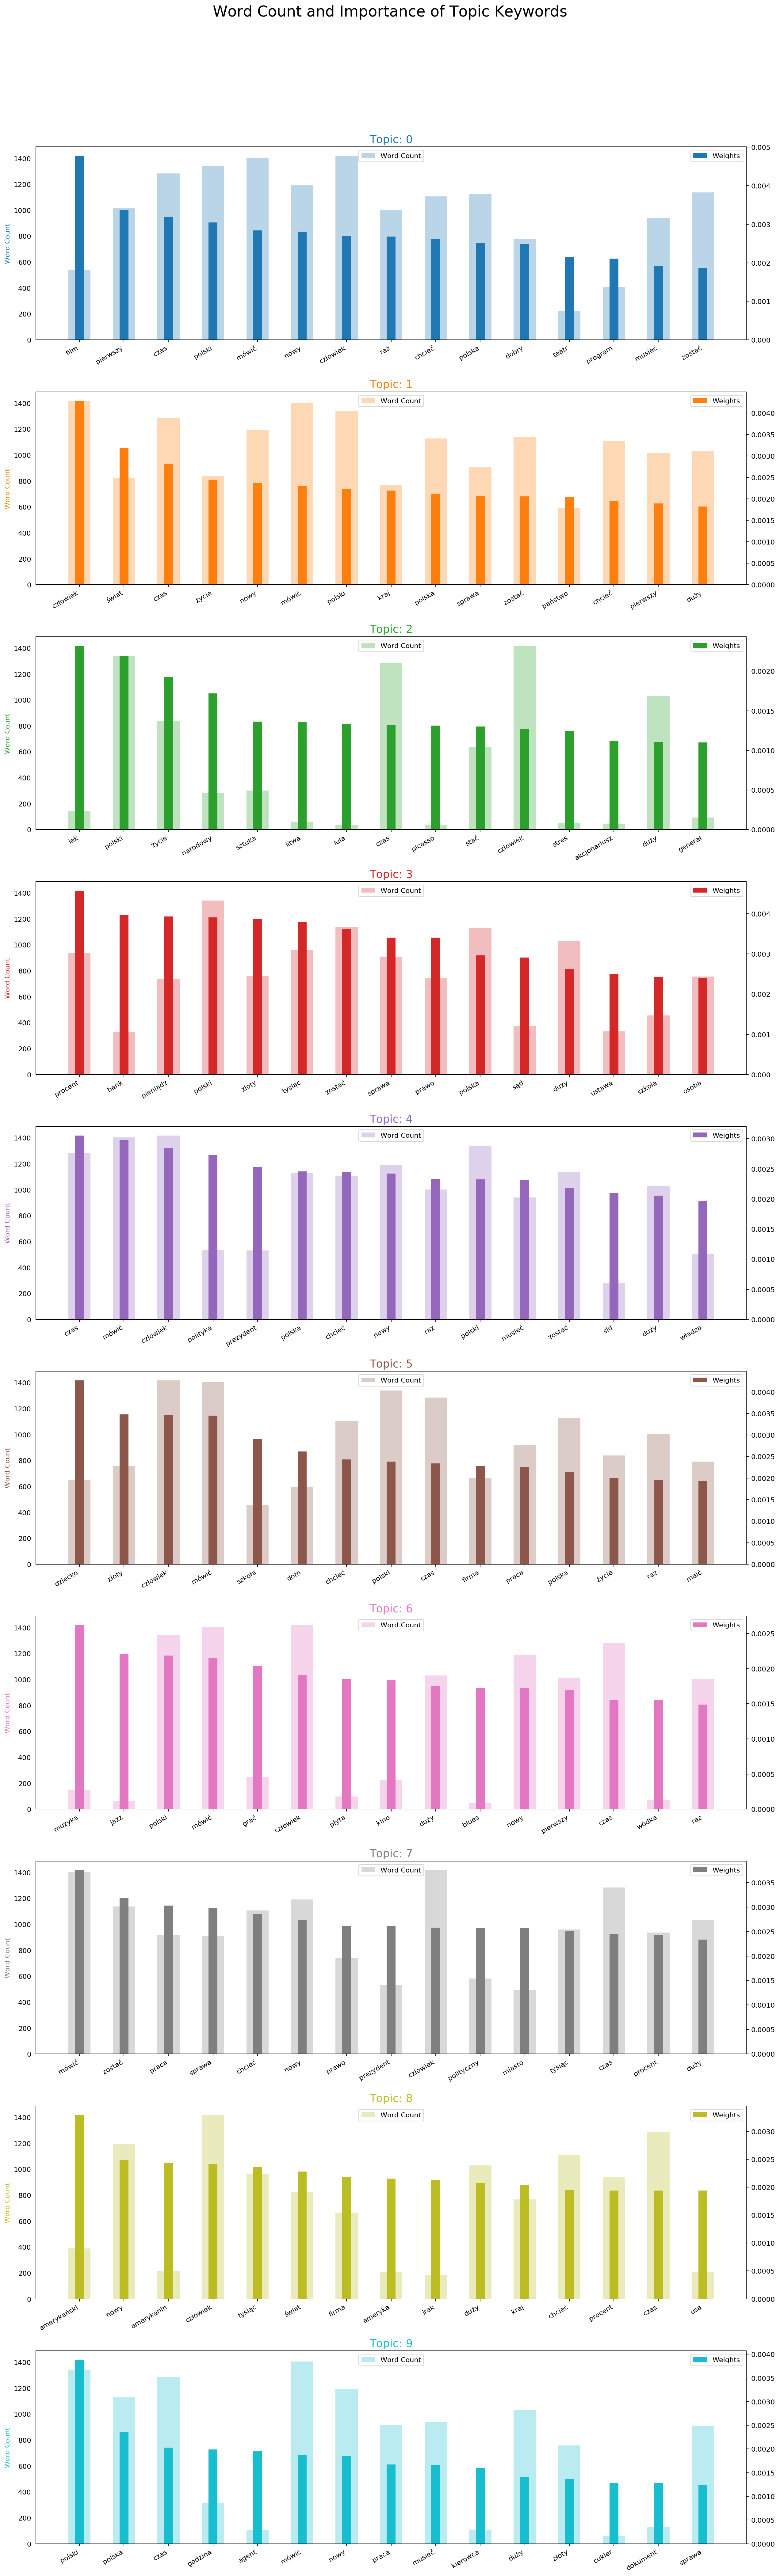

In [46]:
plot_topics(text_data=polityka_text_data, topics_data=polityka_topics, path_to_save=os.path.join(current_path, 'topics_charts.png'))

In [34]:
vis = pyLDAvis.gensim.prepare(topic_model=polityka_model, corpus=polityka_corpus, dictionary=polityka_dictionary)

/Users/alb/Dev/alb/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [47]:
pyLDAvis.save_html(vis, os.path.join(current_path, 'pyLDAvis.html'))